In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers



In [12]:
df = pd.read_csv('creditcard.csv')
df = df.drop(['Time'], axis=1)

scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

X = df.drop(['Class'], axis=1)
y = df['Class']


In [13]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train = X_train[y[X_train.index] == 0]


In [14]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(14, activation='tanh', activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dense(7, activation='relu')(encoded)
decoded = Dense(14, activation='tanh')(encoded)
decoded = Dense(input_dim, activation='relu')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')



In [15]:
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_split=0.1,
                verbose=1)


Epoch 1/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.8724 - val_loss: 0.7415
Epoch 2/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.7414 - val_loss: 0.7236
Epoch 3/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.7227 - val_loss: 0.7152
Epoch 4/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.7283 - val_loss: 0.7105
Epoch 5/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.7154 - val_loss: 0.7039
Epoch 6/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.7026 - val_loss: 0.7048
Epoch 7/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.7038 - val_loss: 0.7007
Epoch 8/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.7197 - val_loss: 0.6984
Epoch 9/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6923 - val_loss: 0.6957
Epoch 10/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.7193 - val_loss: 0.6938
Epoch 11/20
3199/3199 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.6928 - val_loss: 0.6931
Epoch 12/20
3199/3199 

In [16]:
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
threshold = np.percentile(mse, 95)
y_pred = (mse > threshold).astype(int)



1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [17]:
y_true = y[X_test.index]
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))



[[54098  2766]
 [   15    83]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.85      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.52     56962
weighted avg       1.00      0.95      0.97     56962



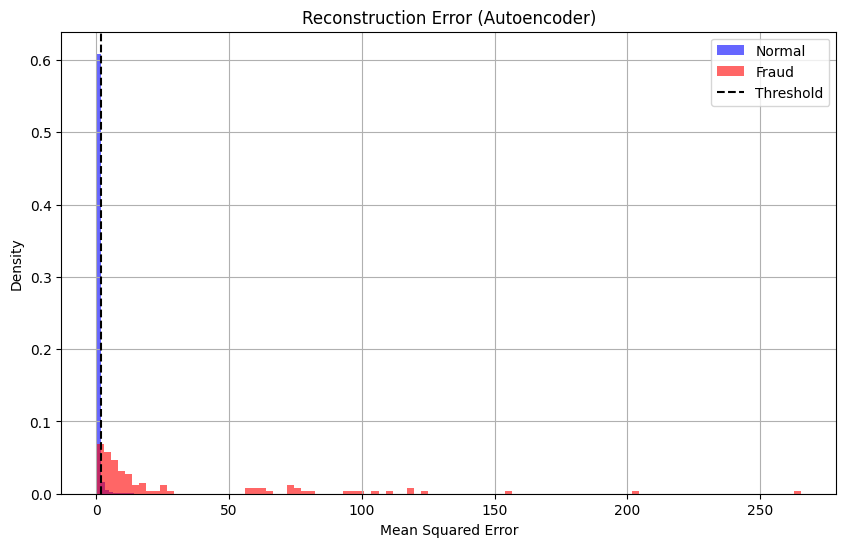

In [19]:
plt.figure(figsize=(10, 6))

normal_mse = mse[y_true == 0]
fraud_mse = mse[y_true == 1]

plt.hist(normal_mse, bins=100, alpha=0.6, label='Normal', color='blue', density=True)
plt.hist(fraud_mse, bins=100, alpha=0.6, label='Fraud', color='red', density=True)

plt.axvline(threshold, color='black', linestyle='--', label='Threshold')

plt.title("Reconstruction Error (Autoencoder)")
plt.xlabel("Mean Squared Error")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


